In [1]:
%load_ext autoreload
%autoreload 2

## Calibrate Camera and save data needed to undistort

- calibrate
- save undistortion variable
- undistort test image

In [2]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.calibrate import calibrate_coeffs

mtx, dist = calibrate_coeffs(directory='camera_cal', rows=6, cols=9)
mtx_dist = {
    'mtx': mtx,
    'dist': dist
}

# save variables
with open('mtx_dist.pickle', 'wb') as handle:
    pickle.dump(mtx_dist, handle, protocol=pickle.HIGHEST_PROTOCOL)

# undistort 'test1.jpg'
img = mpimg.imread('test_images/test1.jpg')
undist = cv2.undistort(img, mtx, dist, None, None)

mpimg.imsave('output_images/test1_undistorted.jpg', undist)

(1280, 720)


## Pipeline

- in cell where each step of image is saved
- as function in order to apply it as a whole

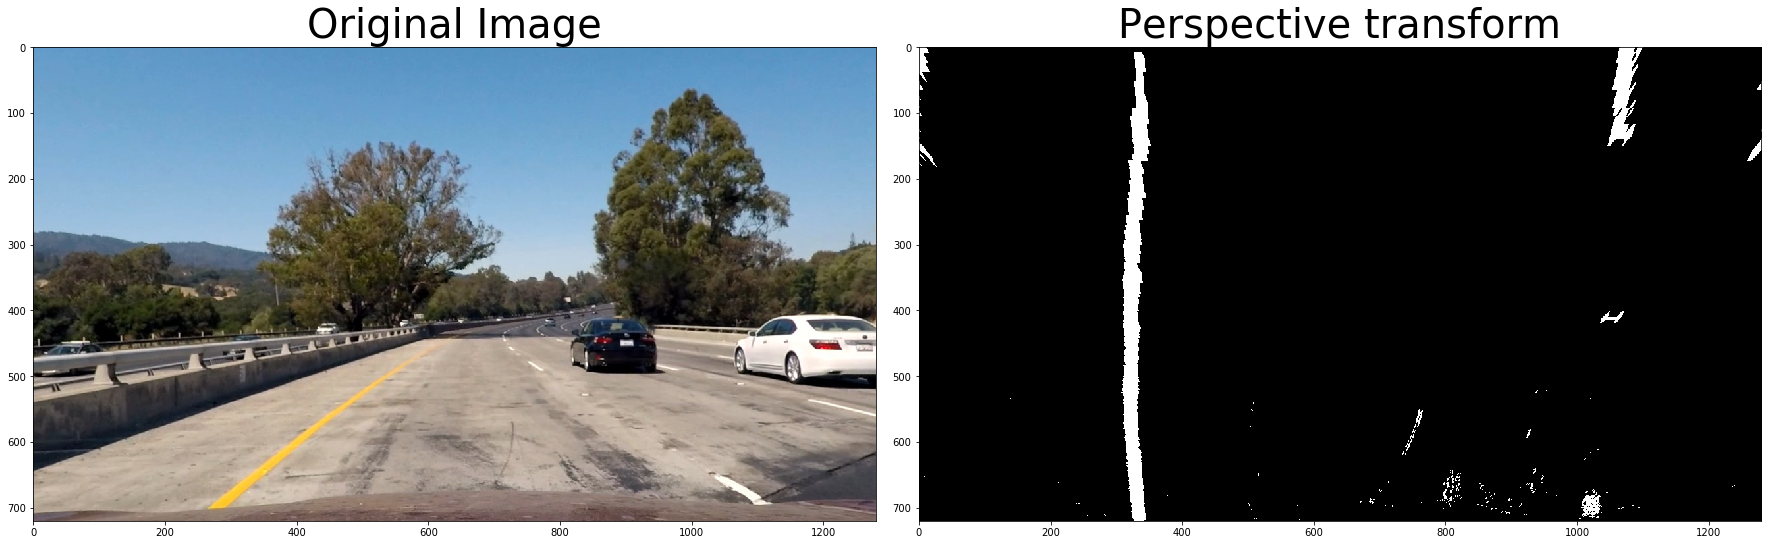

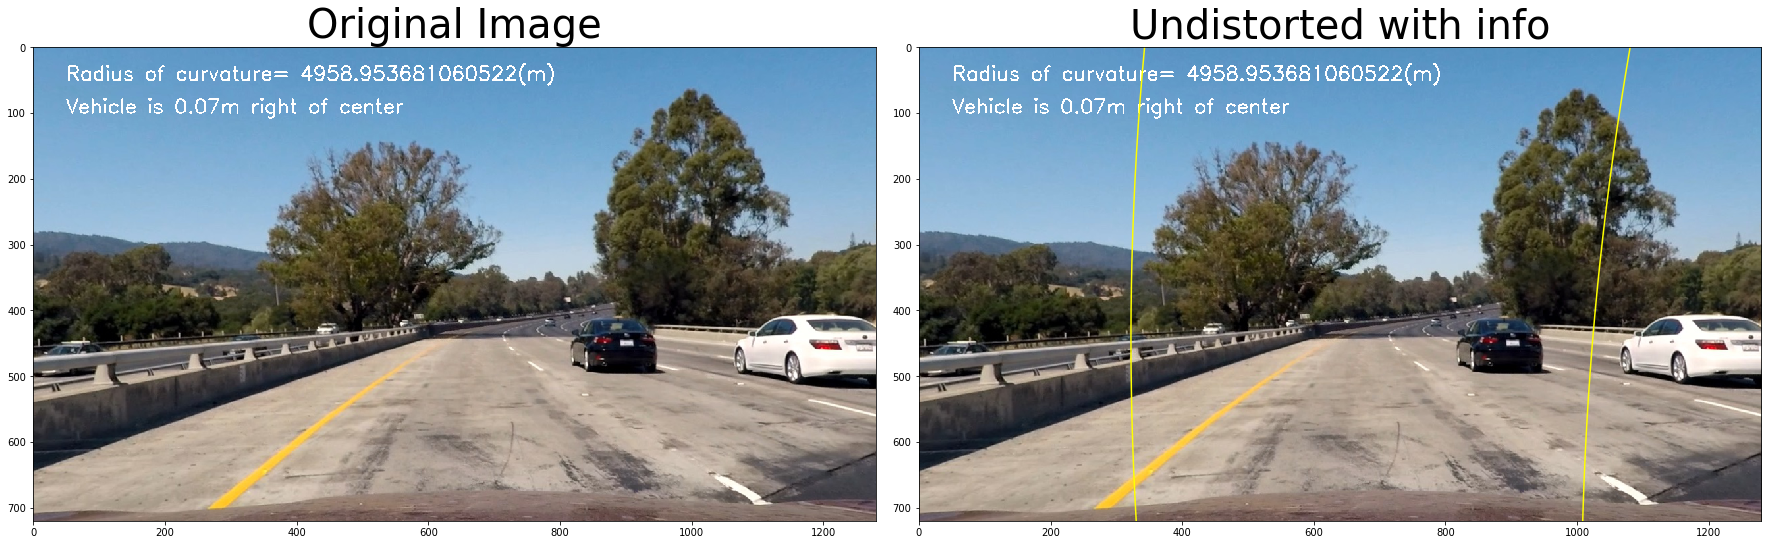

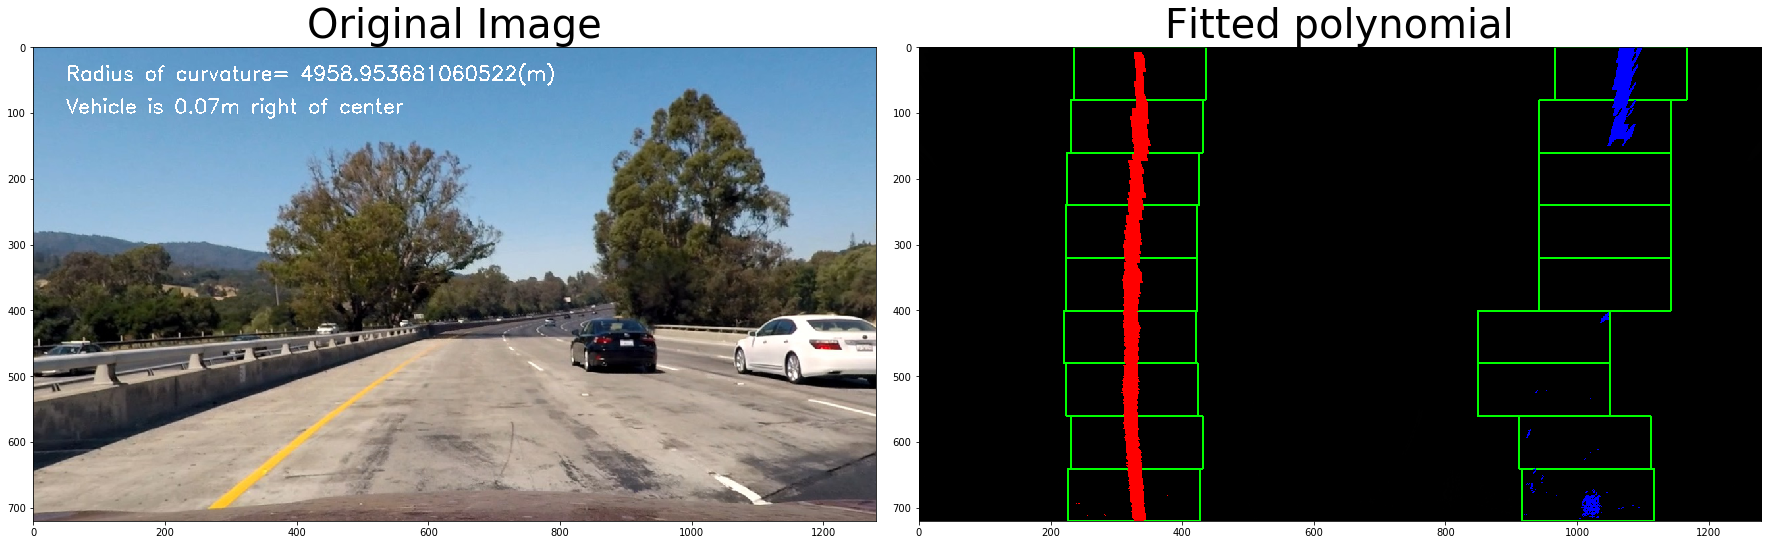

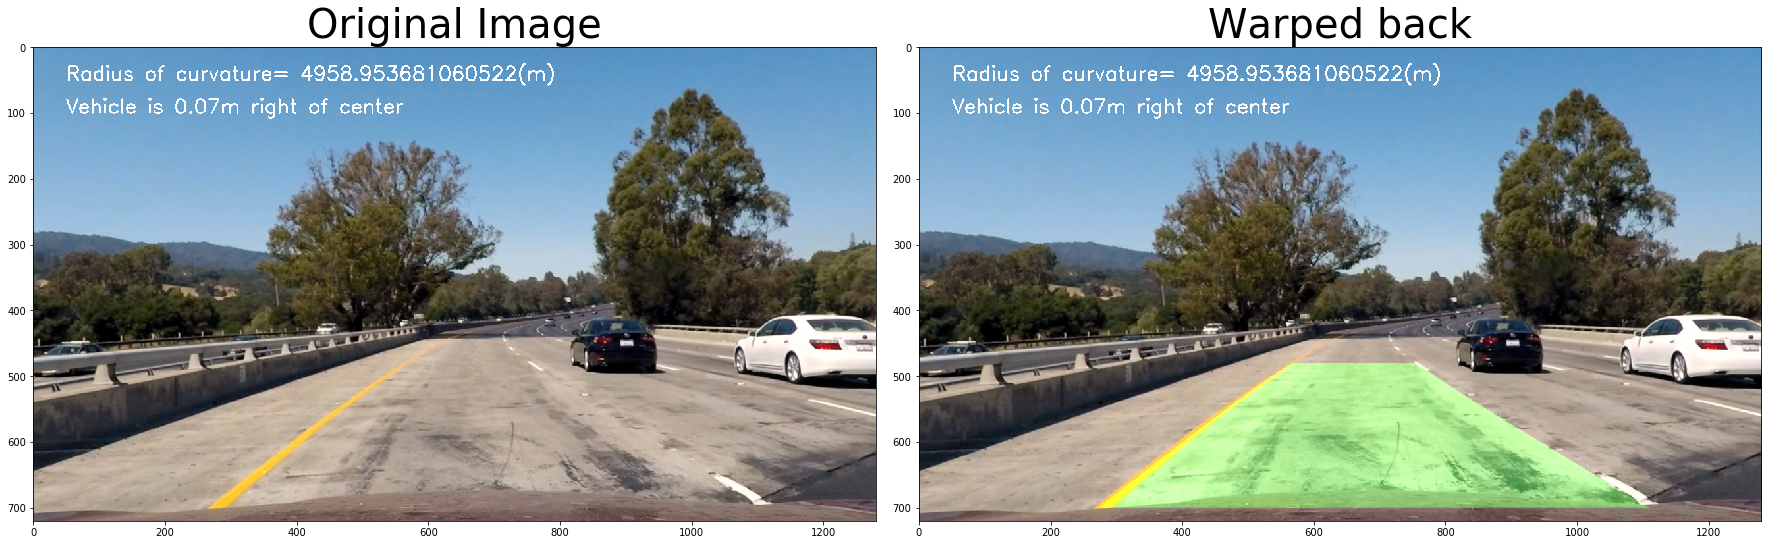

In [3]:
from src.gradient import create_gradient_img
from src.warp import perspective_transform, warp_back
from src.find_lane_pxl import fit_polynomial, measure_curvature, find_lane_pixels
from src.utils import plot_2_img
import matplotlib.image as mpimg
import cv2
import numpy as np

image_name = 'test1'

img = mpimg.imread('test_images/{}.jpg'.format(image_name))
#img = mpimg.imread('test_images/straight_lines1.jpg')#
img_size = (img.shape[1], img.shape[0])


with open('mtx_dist.pickle', 'rb') as handle:
    mtx_dist = pickle.load(handle)
mtx = mtx_dist["mtx"]
dist = mtx_dist["dist"]

# undistort
undist = cv2.undistort(img, mtx, dist, None, mtx)
#plot_2_img(img, undist, 'Undistorted')
mpimg.imsave('output_images/{}_undistorted.jpg'.format(image_name), undist)

# apply threshholding
binary = create_gradient_img(undist)
#plot_2_img(undist, binary, 'Color Gradient')
mpimg.imsave('output_images/{}_binary.jpg'.format(image_name), binary, cmap='gray')

# perspectrive transform
binary_warped, M, Minv = perspective_transform(binary)
plot_2_img(undist, binary_warped, 'Perspective transform')
mpimg.imsave('output_images/{}_binwarped.jpg'.format(image_name), binary_warped, cmap='gray')

leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

dist_from_center, left_curverad, right_curverad = measure_curvature(binary_warped, leftx, lefty, rightx, righty)
radius = (left_curverad + right_curverad) / 2
undist_info = cv2.putText(undist, 'Radius of curvature= {}(m)'.format(radius), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
if dist_from_center < 0:
    undist_info = cv2.putText(undist_info, 'Vehicle is {}m left of center'.format(dist_from_center), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
else:
    undist_info = cv2.putText(undist, 'Vehicle is {}m right of center'.format(dist_from_center), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
plot_2_img(undist, undist_info, 'Undistorted with info')
mpimg.imsave('output_images/{}_info.jpg'.format(image_name), undist)


left_fitx, right_fitx, ploty = fit_polynomial(binary_warped, leftx, lefty, rightx, righty)
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
plot_2_img(undist, out_img, 'Fitted polynomial')
mpimg.imsave('output_images/{}_polynomial.jpg'.format(image_name), out_img)

newwarp = warp_back(undist, binary_warped, left_fitx, right_fitx, ploty, Minv)
plot_2_img(undist, newwarp, 'Warped back')
mpimg.imsave('output_images/{}_final.jpg'.format(image_name), newwarp)



## Put functions together and define pipeline

In [4]:
import cv2
import numpy as np

from src.gradient import create_gradient_img
from src.warp import perspective_transform, warp_back
from src.find_lane_pxl import fit_polynomial, measure_curvature, find_lane_pixels
from src.utils import plot_2_img, add_to_list, avg, diff
from src.line import Line

def pipeline(img):
    #open needed data
    with open('mtx_dist.pickle', 'rb') as handle:
        mtx_dist = pickle.load(handle)
    mtx = mtx_dist["mtx"]
    dist = mtx_dist["dist"]
    # undistort
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # apply threshholding
    binary = create_gradient_img(undist)
    # perspectrive transform
    binary_warped, M, Minv = perspective_transform(binary)
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    dist_from_center, left_curverad, right_curverad = measure_curvature(binary_warped, leftx, lefty, rightx, righty)
    
    dist_from_center, left_curverad, right_curverad = measure_curvature(binary_warped, leftx, lefty, rightx, righty)
    radius = (left_curverad + right_curverad) / 2
    undist_info = cv2.putText(undist, 'Radius of curvature= {}(m)'.format(radius), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    if dist_from_center < 0:
        undist_info = cv2.putText(undist, 'Vehicle is {}m left of center'.format(dist_from_center), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    else:
        undist_info = cv2.putText(undist, 'Vehicle is {}m right of center'.format(dist_from_center), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    left_fitx, right_fitx, ploty = fit_polynomial(binary_warped, leftx, lefty, rightx, righty)

    # update line classes
    left_line.detected = True
    right_line.detected = True
    #if diff(left_curverad, right_curverad) > 3000:
    #    left_line.detected = False
    #    right_line.detected = False
    #if diff(left_line.radius_of_curvature, left_curverad) > 50000:
    #    left_line.detected = False
    
    if diff(right_line.radius_of_curvature, right_curverad) > 50000:
        right_line.detected = False
    if left_line.bestx is not None:
        if diff(left_line.bestx[0], left_fitx[0]) > 50:
            left_line.detected = False
    if right_line.bestx is not None:
        if diff(right_line.bestx[0], right_fitx[0]) > 50:
            right_line.detected = False
    #TODO: 
    if left_line.detected is True or left_line.z >= z:
        if left_line.z >= z:
            left_line.recent_xfitted = []
        left_line.z = 0
        left_line.recent_xfitted = add_to_list(left_line.recent_xfitted, left_fitx, n)
        left_line.bestx = avg(left_line.recent_xfitted)
        left_line.radius_of_curvature = left_curverad
    
    if right_line.detected is True or right_line.z >= z:
        right_line.z = 0
        right_line.recent_xfitted = add_to_list(right_line.recent_xfitted, right_fitx, n)
        right_line.bestx = avg(right_line.recent_xfitted)
        right_line.radius_of_curvature = right_curverad
    
    left_line.z += 1
    right_line.z += 1
    newwarp = warp_back(undist, binary_warped, left_line.bestx, right_line.bestx, ploty, Minv)
    return newwarp

## Run and save video analysis

t:   0%|          | 2/1260 [00:00<01:20, 15.64it/s, now=None]

Moviepy - Building video ./project_video_output.mp4.
Moviepy - Writing video ./project_video_output.mp4



Moviepy - Done !
Moviepy - video ready ./project_video_output.mp4
CPU times: user 3min 53s, sys: 6.74 s, total: 4min
Wall time: 2min 33s


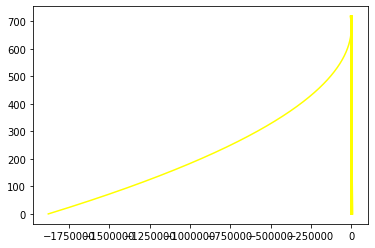

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from src.line import Line

video_name = './project_video.mp4'

left_line = Line()
right_line = Line()
n = 10
z = 10
z_left = 0
z_right = 0

clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile('./project_video_output.mp4', audio=False)

In [6]:
HTML("""
<video widthdraw_lines2(line_img, lines)="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./project_video_output.mp4'))